# Data-reuploading

*Comments:*

The idea was to convert our data representation problem to a classification task in order to be able to use the single-qubit structure allowed with data re-uploads. Fourier points are encoded sequantially onto that qubit x times (x being the number of layers). Then, each data re-upload induce a rotation of the qubit in the Bloch sphere with respect to parameters that we want to optimize. The distance between one of the computational bases (acting as labels here) and the final output vector should be minimized. 

Having an image of the sky, the evident classification task is to determine whether a pixel belongs to a source or not. The model is trained on a 10x10 image randomly generated where 80% of the pixels are dedicated to training, and the remaining points to testing.

Unfortunately, when applying a Fourier transform (FT) to the initial image, the latter the pixels's intensities and spatial information is lost. Hence, it is not possible to learn the boundaries that we were initially interested in. The results below show a poor behaviour from our model. 

Other ways to load data into quantum computers have therfore been explored.

*Data re-uploading:*

* from [paper](https://arxiv.org/abs/1907.02085)
* there is a documentation provided by [PennyLane](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html)
* suggest to follow this nice [tutorial](https://github.com/NLESC-quantum/quantum_comp/blob/main/pulsar_search/ml/reupload/tutorial_data_reuploading_classifier.ipynb) for the pulsars' detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

In [2]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 7) #random number of sources
radius = 1 

for i in range(0, stars):
    index_i = np.random.randint(0, n-radius)
    index_j = np.random.randint(0, n-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

In [3]:
visibilities = np.fft.fft2(sky_image).astype('complex64')

### Training labels

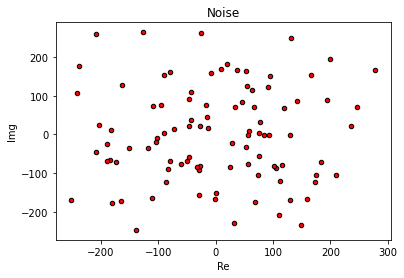

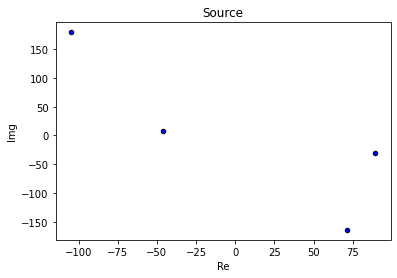

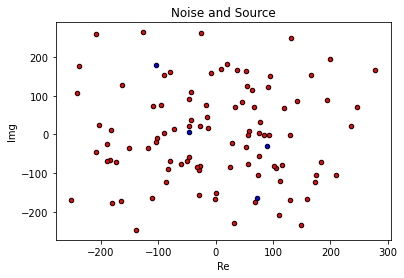

In [4]:
def labels(data, mask):
    
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, ax=None):
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise')
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Source')
    plt.show()
    
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise and Source')
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
plot_data(Xdata, ydata)


# Define output labels as quantum state vectors
def density_matrix(state):
    
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [5]:
dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches

In [6]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the visibilities

In [7]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
indices = []
for i in range(0, len(X_data)):
    indices.append(i)
random.shuffle(indices)

for i in range(0, len(X_data)):
    X_data[i] = X_data[indices[i]]
    y_data[i] = y_data[indices[i]]

index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3 #2
learning_rate = 1e-3 #0.6
epochs = 10 #25
batch_size = 32 #64

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in tqdm(iterate_minibatches(X_train, y_train, batch_size=batch_size)):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

0it [00:00, ?it/s]

Epoch:  0 | Cost: 0.273016 | Train accuracy: 0.437500 | Test Accuracy: 0.650000


2it [00:05,  2.57s/it]
0it [00:00, ?it/s]

Epoch:  1 | Loss: 0.361440 | Train accuracy: 0.437500 | Test accuracy: 0.650000


2it [00:09,  4.81s/it]
0it [00:00, ?it/s]

Epoch:  2 | Loss: 0.359716 | Train accuracy: 0.437500 | Test accuracy: 0.650000


2it [00:09,  4.60s/it]
0it [00:00, ?it/s]

Epoch:  3 | Loss: 0.358004 | Train accuracy: 0.437500 | Test accuracy: 0.650000


2it [00:09,  4.93s/it]
0it [00:00, ?it/s]

Epoch:  4 | Loss: 0.356302 | Train accuracy: 0.437500 | Test accuracy: 0.650000


2it [00:09,  4.56s/it]
0it [00:00, ?it/s]

Epoch:  5 | Loss: 0.354611 | Train accuracy: 0.437500 | Test accuracy: 0.650000


2it [00:09,  4.72s/it]
0it [00:00, ?it/s]

Epoch:  6 | Loss: 0.352933 | Train accuracy: 0.437500 | Test accuracy: 0.650000


2it [00:09,  4.90s/it]
0it [00:00, ?it/s]

Epoch:  7 | Loss: 0.351266 | Train accuracy: 0.475000 | Test accuracy: 0.650000


2it [00:08,  4.31s/it]
0it [00:00, ?it/s]

Epoch:  8 | Loss: 0.349612 | Train accuracy: 0.475000 | Test accuracy: 0.650000


2it [00:08,  4.26s/it]
0it [00:00, ?it/s]

Epoch:  9 | Loss: 0.347970 | Train accuracy: 0.475000 | Test accuracy: 0.650000


2it [00:08,  4.14s/it]


Epoch: 10 | Loss: 0.346342 | Train accuracy: 0.475000 | Test accuracy: 0.650000


### Results

Cost: 0.346342 | Train accuracy 0.475000 | Test Accuracy : 0.650000
Learned weights
Layer 0: [0.62559053 0.0632605  0.84631213]
Layer 1: [0.20549881 0.82082719 0.07372456]
Layer 2: [1.00719484 0.18406292 0.37688035]


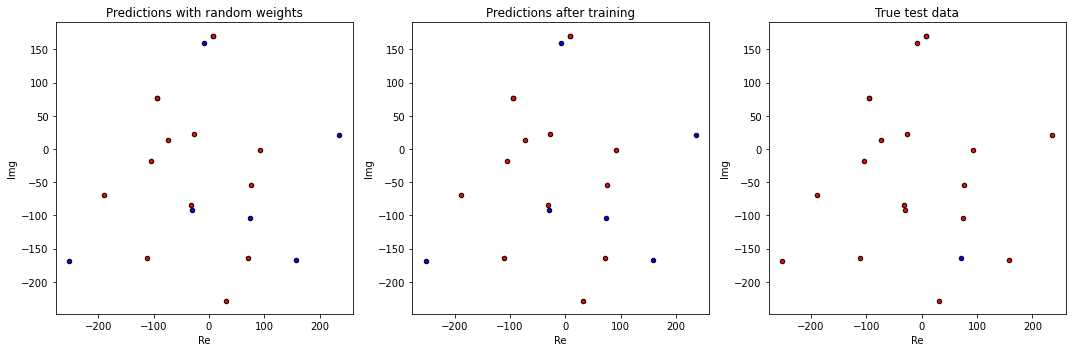

In [8]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
reds = initial_predictions == 0
blues = initial_predictions == 1
axs[0].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[0].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = predicted_test == 0
blues = predicted_test == 1
axs[1].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[1].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = y_test == 0
blues = y_test == 1
axs[2].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[2].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")

axs[0].set_title("Predictions with random weights")
axs[1].set_title("Predictions after training")
axs[2].set_title("True test data")

for ax in axs.flat:
    ax.set(xlabel='Re', ylabel='Img')

plt.tight_layout()
plt.show()